In [1]:
import matplotlib.pyplot as plt
import julian
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
from multiprocessing import Pool

import sys
import os

current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, '..', '..'))
if root_directory not in sys.path:
    sys.path.append(root_directory)

from src.process_image import download_parse_metadata, process_image
from src.process_urls import get_file_urls, process_urls_in_parallel

In [2]:
date_home = 'https://pds-geosciences.wustl.edu/lro/urn-nasa-pds-lro_diviner_derived1/data_derived_gdr_l2/2016/polar/jp2/'
temp_home = 'https://pds-geosciences.wustl.edu/lro/urn-nasa-pds-lro_diviner_derived1/data_derived_gdr_l3/2016/polar/jp2/'

# Get and print all .lbl file URLs from the given page
date_urls = get_file_urls(date_home, '.lbl', 'jd')
temp_urls = get_file_urls(temp_home, '.lbl', 'tbol')
print(f"Found {len(date_urls)} date files and {len(temp_urls)} temp files")

date_urls = date_urls[:5]
temp_urls = temp_urls[:5]

output_csv_path = 'diviner_data.csv'

print("Processing date files...")
combined_date_df = process_urls_in_parallel(date_urls, output_csv_path, 'date')
print("Processing temp files...")
combined_temp_df = process_urls_in_parallel(temp_urls, output_csv_path, 'temp')
print("Files processed successfully")

# Ensure coordinates align between combined DataFrames
if not (combined_date_df[['Longitude', 'Latitude']].equals(combined_temp_df[['Longitude', 'Latitude']])):
    raise ValueError("The coordinates in combined_date_df and combined_temp_df do not align")

# Drop duplicate columns and concatenate
combined_temp_df = combined_temp_df.drop(columns=['Longitude', 'Latitude'])
final_combined_df = pd.concat([combined_date_df, combined_temp_df], axis=1)

Found 42 date files and 42 temp files
Processing date files...


In [ ]:
combined_df = final_combined_df

print(f"Number of NaNs in Julian Dates: {np.isnan(combined_df["date"]).sum()} out of {np.prod(combined_df["date"].shape)} ({(np.isnan(combined_df["date"]).sum()/np.prod(combined_df["date"].shape)*100):.2f}%)")
print(f"Number of NaNs in Temperatures: {np.isnan(combined_df["temp"]).sum()} out of {np.prod(combined_df["temp"].shape)} ({(np.isnan(combined_df["temp"]).sum()/np.prod(combined_df["temp"].shape)*100):.2f}%)\n")
print(f'Min/max longitude: {combined_df["Longitude"].min():.4f}, {combined_df["Longitude"].max():.4f}')
print(f'Min/max latitude: {combined_df["Latitude"].min():.4f}, {combined_df["Latitude"].max():.4f}')
min_jd = np.nanmin(combined_df["date"]); max_jd = np.nanmax(combined_df["date"])
if not np.isnan(min_jd) and not np.isnan(max_jd):
    print(f'Min/max Gregorian date: {julian.from_jd(min_jd, fmt="jd")}, {julian.from_jd(max_jd, fmt="jd")}\n')
print(f'Min/max Temperature: {combined_df["temp"].min():.4f}, {combined_df["temp"].max():.4f}')

Number of NaNs in Julian Dates: 8464679 out of 72656720 (11.65%)
Number of NaNs in Temperatures: 11638135 out of 72656720 (16.02%)

Min/max longitude: 0.0040, 359.9960
Min/max latitude: 74.9185, 105.0815
Min/max Gregorian date: 2016-01-12 18:00:00, 2016-04-03 18:00:00

Min/max Temperature: 37.5400, 351.2600


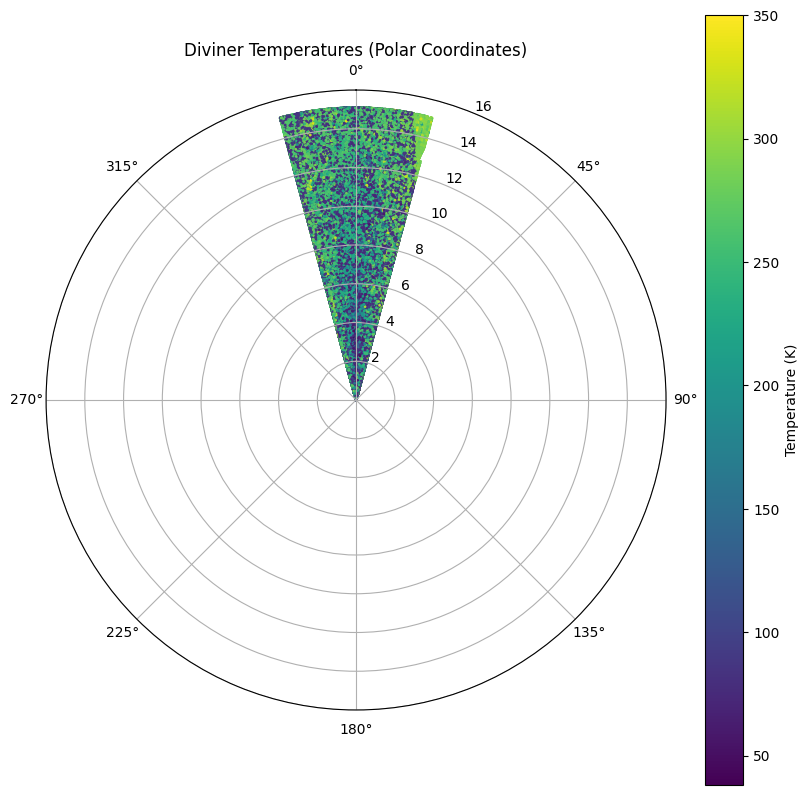

In [ ]:
sampled_df = combined_df.sample(frac=0.06, random_state=42)  # Adjust the fraction as needed

# Convert latitude and longitude to polar coordinates
sampled_df['r'] = 90 - sampled_df['Latitude']
sampled_df['theta'] = np.deg2rad(sampled_df['Longitude'])

plt.figure(figsize=(10, 10))
ax = plt.subplot(111, projection='polar')

sc = ax.scatter(sampled_df['theta'], sampled_df['r'], c=sampled_df['temp'], cmap='viridis', s=1)
plt.colorbar(sc, label='Temperature (K)')
ax.set_ylim(0, 16)  # Set the radius limit to show the polar region more clearly
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_title('Diviner Temperatures (Polar Coordinates)')
plt.show()

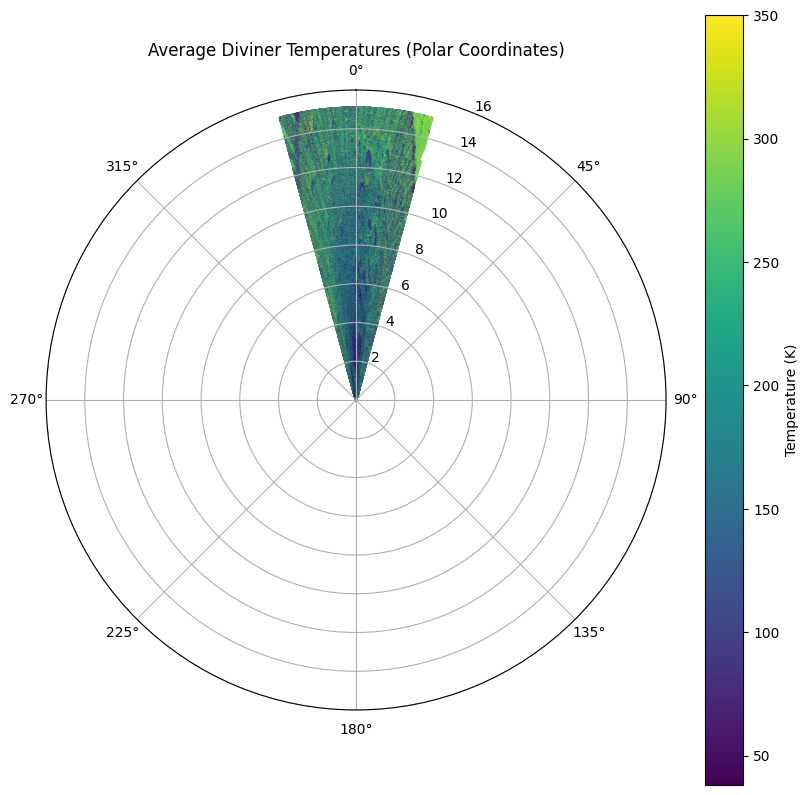

In [ ]:
# Drop 'date' column
sampled_df = sampled_df.drop(columns=['date'])

# Group by 'latitude' and 'longitude' and take the mean of 'temperature'
ave_df = sampled_df.groupby(['Latitude', 'Longitude'], as_index=False).mean()

plt.figure(figsize=(10, 10))
ax = plt.subplot(111, projection='polar')

sc = ax.scatter(ave_df['theta'], ave_df['r'], c=ave_df['temp'], cmap='viridis', s=1)
plt.colorbar(sc, label='Temperature (K)')
ax.set_ylim(0, 16)  # Set the radius limit to show the polar region more clearly
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_title('Average Diviner Temperatures (Polar Coordinates)')
plt.show()
